[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_CAMS.png)](https://atmosphere.copernicus.eu)

# Global Air Quality Index

**Run the tutorial via free cloud platforms**: [![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/cams-act6/main?labpath=08-aqi/cams_glob_eaqi.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/cams-act6/blob/main/08-aqi/cams_glob_eaqi.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/cams-act6/blob/main/08-aqi/cams_glob_eaqi.ipynb)

## Learning objectives

In this notebook we'll compute the forecasts of the global air quality index (AQI). The computation of the AQI forecast is based on the forecast concentration of the following pollutants: $O_3, NO_2, SO_2, PM2.5, PM10$. The index is computed according to the [European Air Quality Index](https://en.wikipedia.org/wiki/Air_quality_index#Europe) definition. The concentration of the pollutants will be time averaged and transformed in $\mu g \cdot m^{-3}$ and finally classified in one of six levels, from *Very good* to *Extremly poor*, according to the threshold levels defined in the European Air Quality Index. The air quality index is the highest value of the concentration levels of the pollutants. For instance, if the concentration level for all the pollutants but $O_3$ is *Very good* but for $O_3$ is *Medium*, then the air quality index is *Medium*.

## Initial setup

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the Climate Data Store (CDS), intalling any other packages not already installed, setting up our CDS API credentials and importing the various Python libraries that we will need.

In [ ]:
# Ensure that the cdsapi package is installed
!pip install -q cdsapi

In [ ]:
# If you are running this notebook in Colab, uncomment the line below and run this cell.
#!pip install cartopy

### Add your ADS API credentials

To set up your ADS API credentials, please login/register on the [ADS](https://ads.atmosphere.copernicus.eu/), then you will see your [unique API key here](https://ads.atmosphere.copernicus.eu/api-how-to). 

You can add this API key to your current session by replacing `#########` in the code cell below with your API key.

In [18]:
import os
os.environ['CDSAPI_URL'] = 'https://ads-beta.atmosphere.copernicus.eu/api'
os.environ['CDSAPI_KEY'] = '###########################################'

### Import libraries

In [19]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcol
from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap
from zipfile import ZipFile
import cdsapi
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("Python version: %s"%python_version())
print("Pandas version: %s"%pd.__version__)
print("Xarray version: %s"%xr.__version__)

Python version: 3.12.5
Pandas version: 2.2.2
Xarray version: 2024.7.0


Here we specify a data directory in which we will download our data and all output files that we will generate:

In [20]:
DATADIR = '.'

## Explore and download data
We use the [CAMS global atmospheric composition forecasts](https://ads-beta.atmosphere.copernicus.eu/datasets/cams-global-atmospheric-composition-forecasts) dataset. The spatial resolution is lower than that available for the [CAMS European air quality forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) used in the previous edition of the training event but it covers the whole planet. The dataset is available from the Copernicus Atmosphere Monitoring Service (CAMS) web service. The spatial grid is 0.4° x 0.4° so that each cell has size 44 km x 44 km, approximately.  In order to compute the air quality index we will download the data of the pollutants and the meteorological data: surface pressure, and 2m air temperature. The trace gases are provided for 137 vertical levels and are available at 3-hourly intervals. We will download the trace gases data only for surface level, that is level 137. The particulate matter and the meteorological data are available at single level at hourly intervals.

* Ozone mass mixing ratio [kg kg**-1]
* Sulphur dioxide mass mixing ratio [kg kg**-1]
* Nitrogen dioxide mass mixing ratio [kg kg**-1]
* Particulate matter d <= 2.5 um [kg m**-3]
* Particulate matter d <= 10 um [kg m**-3]

* Surface pressure [Pa]
* Air temperature [K]

The concentration of the trace gases is given using a dimensionless unit. Since we want to use a common unit for all the pollutants we will have to transform the trace gases data from a dimensionless unit to mass concentration. We will use the surface pressure and the air temperature to perform such transformation. We use the forecast data for two days, starting at 00:00

Visit the [download form for the CAMS global forecast data](https://ads-beta.atmosphere.copernicus.eu/datasets/cams-global-atmospheric-composition-forecasts?tab=download). View the parameters in the API script in the following cell and select the corresponding options.
For the variables, we select in the "Single level" panel

* 2m temperature
* surface pressure
* Particulate matter d < 2.5 µm (PM2.5)
* Particulate matter d < 10 µm (PM10)

In the "Multi level" panel, we select

* Nitrogen dioxide
* Ozone
* Sulphur dioxide

In the "Model level" panel we select 137 (ground level)

For the date, we may select the current date for both start and end date. For the "Time", that is the hour of the beginning of the forecasts we may select 00:00.

In the "Leadtime hour" panel we can flag all the check boxes from 0 to 95 for a 4 days forecast.

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which should contain the same settings as the code cell below.

**Please remember to accept the terms and conditions at the bottom of the download form.**


In [26]:
start_date = '2024-09-13'
end_date = '2024-09-13'
init_hour = '00'
lead_time_start = 0
lead_time_stop = 96
step_hours = 1
leadtime_hours = list(range(lead_time_start, lead_time_stop + lead_time_start, step_hours))

In [27]:
variables = ['2m_temperature',
            'surface_pressure', 
            'particulate_matter_2.5um',
            'particulate_matter_10um',
            'nitrogen_dioxide', 
            'ozone',
            'sulphur_dioxide']
bb_north = 90
bb_south = -90
bb_west = -180
bb_east = 180
area = [bb_north, bb_west, bb_south, bb_east]  

In [28]:
dataset = 'cams-global-atmospheric-composition-forecasts'

In [29]:
request = {
        'variable': variables,
		'date': f'{start_date}/{end_date}',
        'time': f'{init_hour}:00',
        'leadtime_hour': leadtime_hours,
        'model_level': '137',
        'type': 'forecast',
        'area': area,
        'format': 'netcdf_zip'
    }

In [30]:
c = cdsapi.Client()
c.retrieve(
    dataset,
    request,
    f'{DATADIR}/download.zip')

2024-09-13 14:17:16,883 INFO Request ID is 8fd4de07-871e-4ff1-a678-f228371ea3cc
2024-09-13 14:17:16,929 INFO status has been updated to accepted
2024-09-13 14:17:18,480 INFO status has been updated to running
2024-09-13 14:17:20,774 INFO status has been updated to accepted
2024-09-13 14:17:24,179 INFO status has been updated to running
2024-09-13 14:18:31,369 INFO Creating download object as zip with files:
['data_mlev.nc', 'data_sfc.nc']
2024-09-13 14:18:31,372 INFO status has been updated to successful


a32ed55d1e631c022f3459130530ea2c.zip:   0%|          | 0.00/379M [00:00<?, ?B/s]

'./download.zip'

We open the zip file and extract the data into a folder. Trace gases concentration and temperature data are in the multi-level variable set levtype_ml.nc, particulate matter and surface pressure data are in single level variables set levtype_sfc.nc.

In [31]:
with ZipFile(f'{DATADIR}/download.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/')

## Aerosols and meteorological data
The concentration of aerosol PM2.5 and PM10 are provided as densities in $kg \cdot m^{-3}$ 

In [34]:
single_level_ds = xr.open_dataset(f'{DATADIR}/data_sfc.nc') 
single_level_ds

<xarray.Dataset> Size: 623MB
Dimensions:                  (forecast_period: 96, forecast_reference_time: 1,
                              latitude: 451, longitude: 900)
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 768B 00:00:00 ...
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 8B 2024...
  * latitude                 (latitude) float64 4kB 90.0 89.6 ... -89.6 -90.0
  * longitude                (longitude) float64 7kB -180.0 -179.6 ... 179.6
    valid_time               (forecast_reference_time, forecast_period) datetime64[ns] 768B ...
Data variables:
    t2m                      (forecast_period, forecast_reference_time, latitude, longitude) float32 156MB ...
    sp                       (forecast_period, forecast_reference_time, latitude, longitude) float32 156MB ...
    pm2p5                    (forecast_period, forecast_reference_time, latitude, longitude) float32 156MB ...
    pm10                     (forecast_period, forecast_reference_time, latitude, longitude) float32 156MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-13T12:17 GRIB to CDM+CF via cfgrib-0.9.1...

## Trace gases
The concentration of the trace gases is provided as mixing ratio, a dimensionless quantity that represents the ratio between the mass concentration of the trace gas, in kg per unit volume, and the mass concentration of air.  

In [35]:
multi_level_ds = xr.open_dataset(f'{DATADIR}/data_mlev.nc') 
multi_level_ds

<xarray.Dataset> Size: 156MB
Dimensions:                  (forecast_period: 32, forecast_reference_time: 1,
                              model_level: 1, latitude: 451, longitude: 900)
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 256B 00:00:00 ...
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 8B 2024...
  * model_level              (model_level) float64 8B 137.0
  * latitude                 (latitude) float64 4kB 90.0 89.6 ... -89.6 -90.0
  * longitude                (longitude) float64 7kB -180.0 -179.6 ... 179.6
    valid_time               (forecast_reference_time, forecast_period) datetime64[ns] 256B ...
Data variables:
    no2                      (forecast_period, forecast_reference_time, model_level, latitude, longitude) float32 52MB ...
    go3                      (forecast_period, forecast_reference_time, model_level, latitude, longitude) float32 52MB ...
    so2                      (forecast_period, forecast_reference_time, model_level, latitude, longitude) float32 52MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-13T12:17 GRIB to CDM+CF via cfgrib-0.9.1...

## Scaling factor
We calculate the scaling factor, to convert the dimensionless mixing ratios of $NO_2, SO_2$, and $O_3$ from kg/kg to mass density in ug/m3, using the air surface pressure, the temperature. We start from the definition of mass mixing ratio of a chemical species X in air

$$\alpha_x = \frac{\rho_x}{\rho}$$

where $\rho_x$ is the mass density of the chemical species X in $kgm^{-3}$ and $\rho$ is the mass density of the air. We assume the trace gases and the dry air to follow the ideal gas law so that for dry air we can write

$$pV = nRT$$

where p is the air pressure, $R = K_B N_A = 8.314 \text{ } JK^{-1}mol^{-1}$ is the ideal gas constant, where $K_B$ is the Boltzmann constant and $N_A$ is the Avogadro's number, V the volume, T the temperature, and finally n is the number of moles. The number of moles is defined as the ratio of the mass and the molar mass. For dry air, a mixture of several gases, the molar mass $M_a$ can be represented by the weighted sum of the molar masses of all the chemical species in the air (see Jacob, chap.1, p.4)

$$M_a = \sum_i w_iM_i = 28.96 \cdot 10^{-3} \text{ } kg\text{ }mol^{-1}$$

With this defnition the number of moles of dry air can be written as

$$n = \frac{m}{M_a}$$
 
where m is the mass of the dry air. Substituting this definition into the gas law for dry air we have

$$pV = \frac{m}{M_a}RT$$

We can define the gas constant of dry air from the ideal gas constant R and the molar mass of dry air

$$R_a = \frac{R}{M_a} = \frac{8.314 \text{ } JK^{-1}mol^{-1}}{28.96 \cdot 10^{-3} \text{ } kg\text{ }mol^{-1}} = 287.08 \text{ } JK^{-1}kg^{-1}$$

We can now write the law for dry air as

$$pV = mR_aT$$

and

$$p = \frac{m}{V}R_aT = \rho R_aT$$

so that the mass density of dry air is

$$\rho = \frac{p}{R_aT}$$

from which we can write the equation of the mass density of a chemical species in the air as a function of its mixing ratio, the air pressure and temperature, and given the air specific gas constant

$$\rho_x = \alpha_x \frac{p}{R_aT} \text{ } kg m^{-3}$$

If we define the factor c as

$$c = \frac{p}{R_aT}$$

we can transform the mixing ratio of a chemical species to mass density using the equation

$$\rho_x = c \alpha_x$$

We calculate the scaling factor

In [36]:
R = 287.08
cfactor = single_level_ds['sp'] / (R * single_level_ds['t2m'])

With the scaling factor we can transform the concentration values of the trace gases into $kg \cdot m^{-3}$. Then, we multiply for $10^9$ to represent the values in $\mu g \cdot m^{-3}$

In [37]:
trace_gases = ['no2','go3','so2']
for gas in trace_gases:
    multi_level_ds[gas] = multi_level_ds[gas] * cfactor * 1e9

In [38]:
particulate_matter = ['pm2p5','pm10']
for param in particulate_matter:
    single_level_ds[param] = single_level_ds[param] * 1e9

## 24h max and mean average
We aggregate the data by computing the maximun daily values of the trace gases concentration and mean daily values of the particulate matter concentration.

In [39]:
multi_level_max = multi_level_ds.resample(valid_time='1D').max()
multi_level_max = multi_level_max.squeeze(drop=True)

In [40]:
single_level_mean = single_level_ds.resample(valid_time='1D').mean()
single_level_mean = single_level_mean.squeeze(drop=True)

We merge the trace gases and the particulate matter into one array

In [41]:
eaqi_daily = xr.merge([single_level_mean, multi_level_max])

In [42]:
eaqi_daily = eaqi_daily.drop_vars(["t2m", "sp"])

In [49]:
eaqi_daily

<xarray.Dataset> Size: 32MB
Dimensions:     (valid_time: 4, latitude: 451, longitude: 900)
Coordinates:
  * latitude    (latitude) float64 4kB 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude   (longitude) float64 7kB -180.0 -179.6 -179.2 ... 179.2 179.6
  * valid_time  (valid_time) datetime64[ns] 32B 2024-09-13 ... 2024-09-16
Data variables:
    pm2p5       (valid_time, latitude, longitude) float32 6MB 1.793 ... 0.001853
    pm10        (valid_time, latitude, longitude) float32 6MB 3.712 ... 0.002621
    no2         (valid_time, latitude, longitude) float32 6MB 0.008997 ... 0....
    go3         (valid_time, latitude, longitude) float32 6MB 74.8 ... 55.52
    so2         (valid_time, latitude, longitude) float32 6MB 0.002042 ... 0....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-13T12:17 GRIB to CDM+CF via cfgrib-0.9.1...

## Quantiles
We calculate several quantiles for each variable. We use the quantiles to define the level of concentration for visualization.

In [43]:
def contour_quantiles(xr_da):
    """
    This function can be used to calculate the contour levels
    for plotting. 
    """
    quantiles = [0.0]
    #partition_values = np.arange(start=0.1, stop=1.1, step=0.1)
    partition_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999]
    last_quantile = 0.0
    for i in range(len(partition_values)):
        value = partition_values[i]
        quantile = round(xr_da.quantile(value).item(), 2)
        if (quantile - last_quantile > 0.0):
            quantiles.append(quantile)
            last_quantile = quantile
    return quantiles

Now we use the functions defined above to calculate a summary statistics of the variables

In [44]:
no2_levels = contour_quantiles(eaqi_daily['no2'])
o3_levels = contour_quantiles(eaqi_daily['go3'])
so2_levels = contour_quantiles(eaqi_daily['so2'])
pm25_levels = contour_quantiles(eaqi_daily['pm2p5'])
pm10_levels = contour_quantiles(eaqi_daily['pm10'])

In [45]:
params = ['no2','go3','so2','pm2p5','pm10']
all_levels = [no2_levels, o3_levels, so2_levels, pm25_levels, pm10_levels]

## Plotting the global concentrations of trace gases and particulate matter
From the shape of the dataset (height and width) and the spatial resolution we should be able to calculate the global area that should be equal top the Earth surface. 

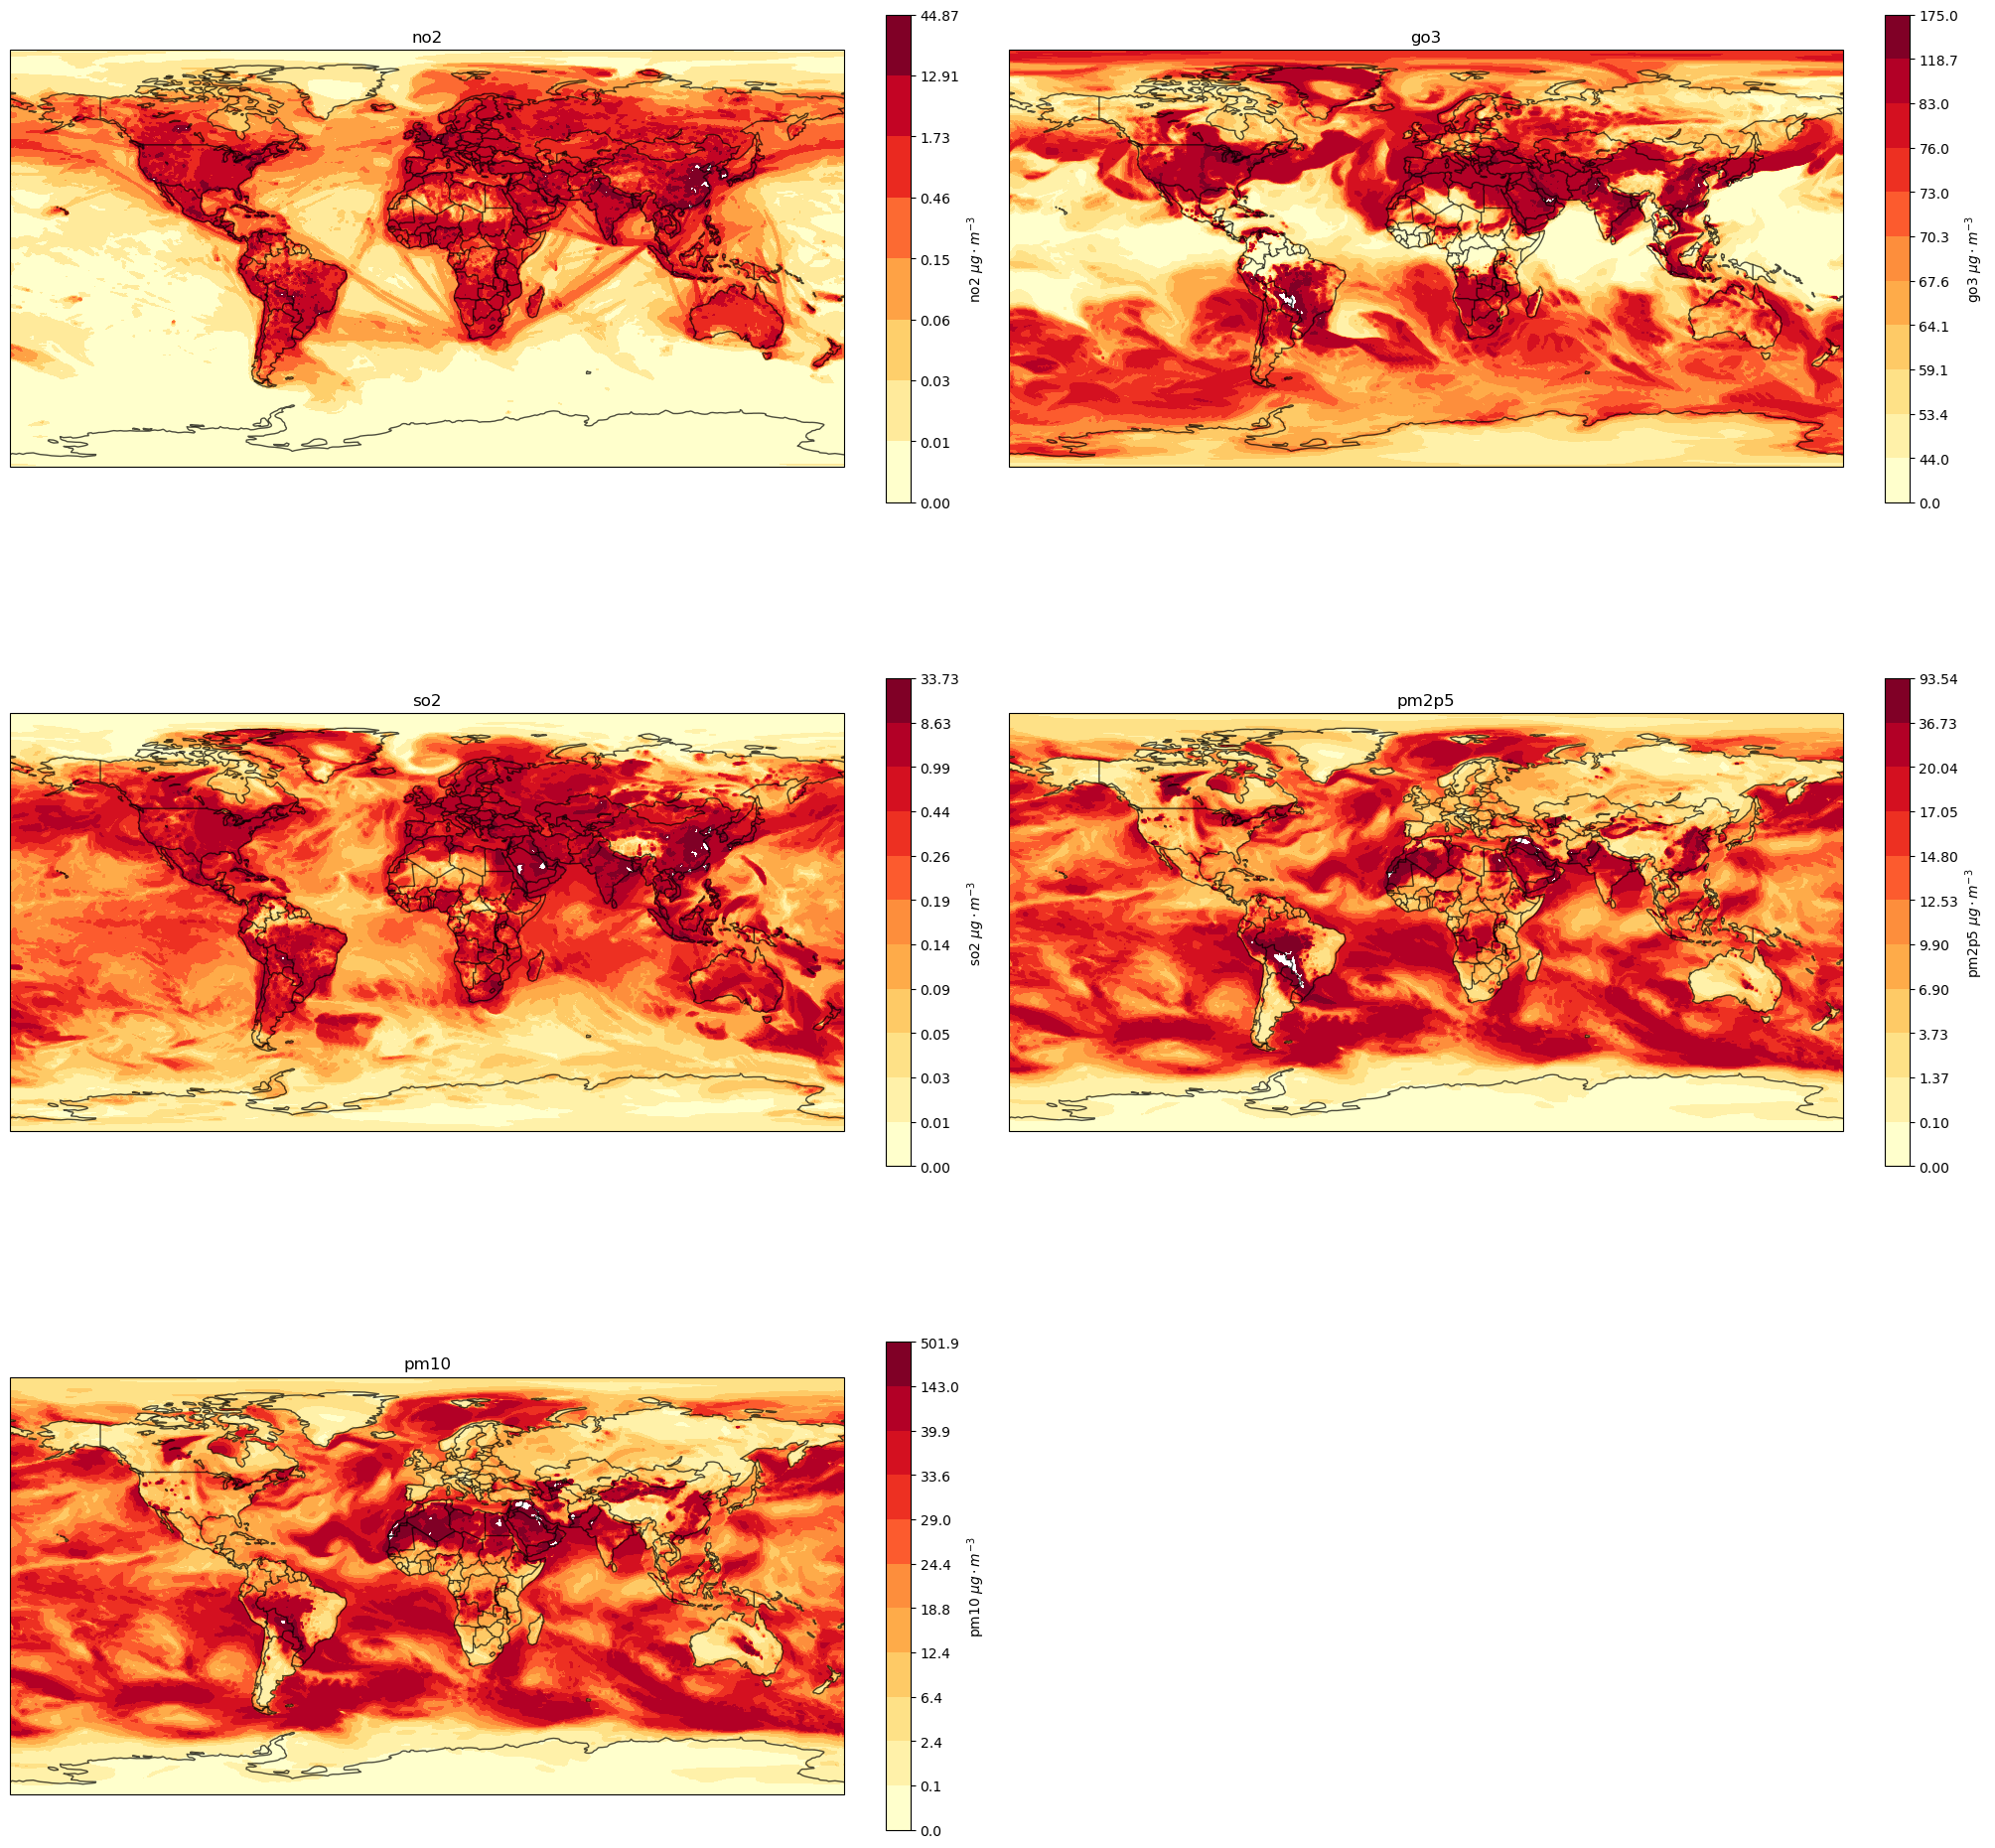

In [46]:
fig, axs = plt.subplots(nrows=3, ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20, 20), layout='constrained') 
axs = axs.flatten()
fig.delaxes(axs[5])
for i, param in enumerate(params):
    da = eaqi_daily[param]
    clevs = all_levels[i]
    day_index = 0
    data = da[day_index,:,:]
    #data = da[:,:]
    #vmin = da.min()
    #vmax = da.max() 
    cs = axs[i].contourf(da.longitude, da.latitude, data, 
                        levels = clevs, 
                        #vmin=0.0, 
                        #vmax=vmax,
                        cmap='YlOrRd', # 'RdYlBu_r', 
                        norm = mcol.BoundaryNorm(clevs, 256), 
                        transform=ccrs.PlateCarree())

    cbar = plt.colorbar(cs, fraction=0.046, pad=0.05, orientation='vertical', shrink=0.75, ticks=clevs)
    cbar.set_label(param + ' $\mu g \cdot m^{-3}$')
    #axs[i].set_yticklabels(clevs)
    axs[i].set_extent([bb_west, bb_east, bb_south, bb_north], crs=ccrs.PlateCarree()) 
    axs[i].set_title(param)
    axs[i].coastlines(color='black', alpha=0.7) 
    axs[i].add_feature(cfeature.LAKES, alpha=0.7, edgecolor='black', facecolor='none')
    axs[i].add_feature(cfeature.BORDERS, alpha=0.7)
    axs[i].margins(0.1)

## Calculating the air quality index
An algorithm to calculate the AQI is described in p.18 of the US Air Quality Index [Technical Assistance Document for the Reporting of Daily Air Quality](https://www.airnow.gov/publications/air-quality-index/technical-assistance-document-for-reporting-the-daily-aqi/)  
The air quality index of the chemical species X can be calculated using the equation

$$I_x = \frac{I_{high} - I_{low}}{C_{high} - C_{low}}(C_x - C_{low}) + I_{low}$$



|$NO_2$ $(\mu g/m^3)$|$O_3$ $(\mu g/m^3)$|$SO_2$ $(\mu g/m^3)$|$PM2.5$ $(\mu g/m^3)$|$PM10$ $(\mu g/m^3)$| AQI|Category|
|---------|--------|------|-----------|------------|--------|-------|
| 0-40 | 0-50 | 0-100| 0-10 | 0-20|1|Good|
| 40-90 | 50-100 | 100-200 | 10-20 | 20-40 | 2|Fair|
| 90-120 | 100-130 | 200-350 | 20-25 | 40-50 | 3|Moderate|
| 120-230 | 130-240 | 350-500 | 25-50 | 50-100 | 4|Poor|
| 230-340 | 240-380 | 500-750 | 50-75 | 100-150 | 5|Very Poor|
| 340-1000 | 380-800 | 750-1250 | 75-800 | 150-1200 | 6|Extremely Poor|

In [64]:
no2_limits = [0, 40, 90, 120, 230, 340, 1000]
o3_limits = [0, 50, 100, 130, 240, 380, 800]
so2_limits = [0, 100, 200, 350, 500, 750, 1250]
pm25_limits = [0, 10, 20, 25, 50, 75, 800]
pm10_limits = [0, 20, 40, 50, 100, 150, 1200]

bin_list = [no2_limits, o3_limits, so2_limits, pm25_limits, pm10_limits]
bin_list

[[0, 40, 90, 120, 230, 340, 1000],
 [0, 50, 100, 130, 240, 380, 800],
 [0, 100, 200, 350, 500, 750, 1250],
 [0, 10, 20, 25, 50, 75, 800],
 [0, 20, 40, 50, 100, 150, 1200]]

In [52]:
eaqi_daily.coords['valid_time']

<xarray.DataArray 'valid_time' (valid_time: 4)> Size: 32B
array(['2024-09-13T00:00:00.000000000', '2024-09-14T00:00:00.000000000',
       '2024-09-15T00:00:00.000000000', '2024-09-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 32B 2024-09-13 ... 2024-09-16
Attributes:
    standard_name:  time
    long_name:      time

In [53]:
for t in eaqi_daily.coords['valid_time']:
    timestamp = t
    day = str(timestamp.values)[:10]
    hour = str(timestamp.values)[11:16]
    print(day + ' ' + hour)

2024-09-13 00:00
2024-09-14 00:00
2024-09-15 00:00
2024-09-16 00:00


In [56]:
first_forecast = eaqi_daily.sel(valid_time='2024-09-13')
first_forecast

<xarray.Dataset> Size: 8MB
Dimensions:     (latitude: 451, longitude: 900)
Coordinates:
  * latitude    (latitude) float64 4kB 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude   (longitude) float64 7kB -180.0 -179.6 -179.2 ... 179.2 179.6
    valid_time  datetime64[ns] 8B 2024-09-13
Data variables:
    pm2p5       (latitude, longitude) float32 2MB 1.793 1.793 ... 0.02587
    pm10        (latitude, longitude) float32 2MB 3.712 3.712 ... 0.03704
    no2         (latitude, longitude) float32 2MB 0.008997 0.008997 ... 0.001178
    go3         (latitude, longitude) float32 2MB 74.8 74.8 74.8 ... 54.03 54.03
    so2         (latitude, longitude) float32 2MB 0.002042 0.002042 ... 0.01282
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-13T12:17 GRIB to CDM+CF via cfgrib-0.9.1...

In [57]:
def classify_forecast_variables(forecast_ds):
    '''
    This function assigns an integer value according to a class 
    for each float value in the dataset.
    '''
    classified_arrays = []
    for i in range(0, len(forecast_ds)):
        variable = params[i]
        temp = xr.apply_ufunc(np.digitize,
                              forecast_ds[variable],
                              bin_list[i])
        classified_arrays.append(temp)
        combined_arrays = xr.merge(classified_arrays)
        final_index = combined_arrays.to_array().max('variable')
    return final_index

In [59]:
final_index = classify_forecast_variables(eaqi_daily)

We define a colormap for the AQI

In [72]:
good_color = '#03fcf0'
fair_color = '#16d984'
moderate_color = '#dffa11'
poor_color = '#db4918'
very_poor_color = '#873c23'
extremely_poor_color = '#5a2387'
colors = [good_color, fair_color, moderate_color, poor_color, very_poor_color, extremely_poor_color]
labels = ['Good', 'Fair', 'Moderate', 'Poor', 'Very Poor', 'Extremely Poor']
levels = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
level_ticks = [1, 2, 3, 4, 5, 6]
aqi_cmap = ListedColormap(colors)

## Global AQI map

In [73]:
number_of_forecasts = 1
#plot_global_aqi_maps(final_index[7], params, levels, aqi_cmap, level_ticks, labels)

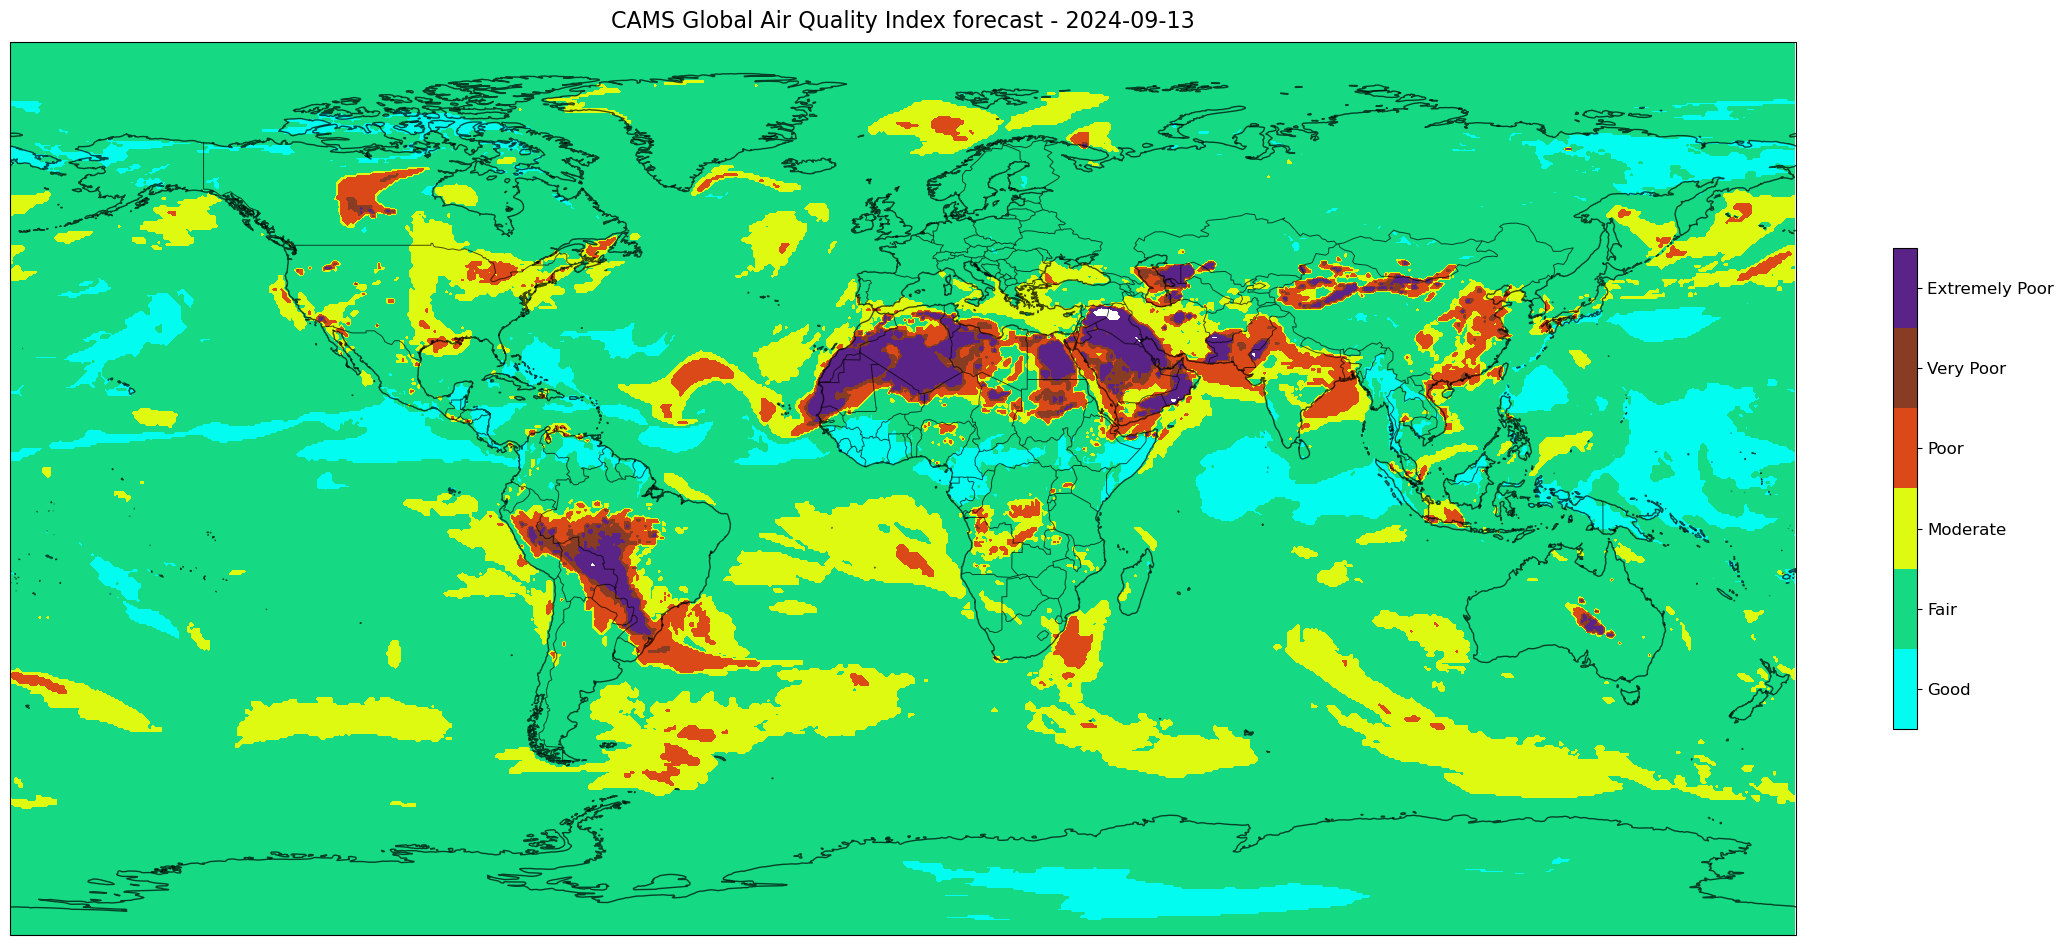

In [74]:
number_of_forecasts = 1
fig, ax = plt.subplots(
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(25, 25))
i = 0
#for i in range(number_of_forecasts):
data = final_index[0]
#data = final_index
timestamp = final_index.valid_time
day = str(timestamp.values[i])[:10]
hour = str(timestamp.values[i])[11:16]
cs=ax.contourf(final_index.longitude, 
                       final_index.latitude, 
                       data,
                       levels=levels, 
                       #vmin=1, 
                       #vmax=6, 
                       cmap=aqi_cmap,
                       transform=ccrs.PlateCarree())
    
ax.set_title('CAMS Global Air Quality Index forecast - ' + day, fontsize=16, pad=10.0)
ax.coastlines(color='black', alpha=0.7, resolution='50m')
ax.add_feature(cfeature.BORDERS, alpha=0.7, linewidth=0.7)
ax.set_extent([bb_west, bb_east, bb_south, bb_north], crs=ccrs.PlateCarree())
    
# Customize colorbar
cbar = plt.colorbar(cs, fraction=0.028, pad=0.05, shrink=0.25) 
cbar.set_label(None)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(level_ticks)
cbar.set_ticklabels(labels)

## References
* [Jacob - Introduction to Atmospheric Chemistry](https://acmg.seas.harvard.edu/education/introduction-atmospheric-chemistry)
* Wilks - Statistical Methods in Atmospheric Science, 2nd Edition